# Visualizing TensorFlow Graphs in Jupyter Notebooks

# rerequisites: This article assumes you are familiar with the basics of Python, TensorFlow, and Jupyter notebooks. We won't use any of the advanced TensorFlow features, as our goal is just to visualize the computation graphs.
TensorFlow operations form a computation graph. And while for small examples you might be able to look at the code and immediately see what is going on, larger computation graphs might not be so obvious. Visualizing the graph can help both in diagnosing issues with the computation itself, but also in understanding how certain operations in TensorFlow work and how are things put together.
We'll take a look at a few different ways of visualizing TensorFlow graphs, and most importantly, show how to do it in a very simple and time-efficient way. It shouldn't take more than one or two lines of code to draw a graph we have already defined. Now onto the specifics, we'll take a look at the following visualization techniques:
Exploring the textual graph definition
Building a GraphViz DOTgraph from that directly in the Jupyter Notebook
Visualizing the same graph in a locally running instance of TensorBoard
Using a self contained snippet that uses a cloud deployed publically available TensorBoard instance to render the graph inline in a Jupyter Notebook.
First, let us create a simple TensorFlow graph. Regular operations such as creating a placeholder with tf.placeholder will create a node in the so called default graph. We can access it via tf.get_default_graph(), but we can also change it temporarily. In our example below, we'll create a new instance of the tf.Graph object and create a simple operation adding two variables
c=a+b
 
Note that we're giving explicit names to both of the placeholder variables.

In [1]:
import tensorflow as tf

g = tf.Graph()

with g.as_default():
    a = tf.placeholder(tf.float32, name="a")
    b = tf.placeholder(tf.float32, name="b")
    c = a + b


The variable g now contains a definition of the computation graph for the operation  c=a+b
 . We can use the g.as_graph_def() method to get a textual representation of the graph for our expression. While the main use of this is for serialization and later deserialization via tf.import_graph_def, we'll use it to create a GraphViz DOTgraph.

Let us take a look at the GraphDef for our simple expression. First, we'll inspect the names of all of the nodes in the graph.

In [2]:
[node.name for node in g.as_graph_def().node]

['a', 'b', 'add']

As expected, there are three nodes in the Graph. One for each of our variables, and one for the addition opeartion. The placeholder variable nodes have a name since we explicitely named them when calling tf.placeholder. If we omit the name keyword argument, TensorFlow will simply generate a name on its own, as it did with the add operation.

Next, we can take a look at the edges in the graph. Each GraphDef node has an input field which specifies of the nodes where it has edges. Let's take a look:

In [3]:
g.as_graph_def().node[2].input

['a', 'b']

As we can see, there are two edges, one to each variable. We can feed this directly into GraphViz.

# Building a GraphViz DOTgraph

GraphViz is a fairly popular library for drawing graphs, trees and other graph-shaped data structures. We'll use the Python GraphViz package which provides a nice clean interface. We can install it directly inside a Jupyter notebook via !pip install graphviz.

The graph definition itself will be rather simple, and we'll take inspiration from a similar piece of code in TensorFlow itself (in graph_to_dot.py) which generates a DOTgraph file format for a given GraphDef. Unfortunately it is only available as a command line script, and as such we can't call it directly from our code. This is why we'll be implementing it ourselves, but don't worry, it will only be a few lines of code

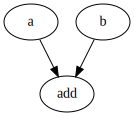

In [4]:
from graphviz import Digraph

dot = Digraph()

for n in g.as_graph_def().node:
    # Each node has a name and a label. The name identifies the node
    # while the label is what will be displayed in the graph.
    # We're using the name as a label for simplicity.
    dot.node(n.name, label=n.name)
    
    for i in n.input:
        # Edges are determined by the names of the nodes
        dot.edge(i, n.name)
        
# Jupyter can automatically display the DOT graph,
# which allows us to just return it as a value.
dot

Now let's wrap this in a function and try using it on a more complicated expression.

In [5]:
def tf_to_dot(graph):
    dot = Digraph()

    for n in g.as_graph_def().node:
        dot.node(n.name, label=n.name)

        for i in n.input:
            dot.edge(i, n.name)
            
    return dot

We'll build another graph calculating the area of a circle with the formula  π∗r2
 . As we can see TensorFlow does what we would actually expect and links the same placeholder to two multiplication operations.

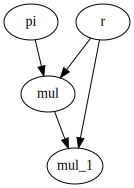

In [6]:
g = tf.Graph()

with g.as_default():
    pi = tf.constant(3.14, name="pi")
    r = tf.placeholder(tf.float32, name="r")
    
    y = pi * r * r
    
tf_to_dot(g)

# Using a local TensorBoard instance to visualize the graph

While GraphViz might be nice for visualizing small graphs, neural networks can grow to quite a large size. TensorBoard allows us to easily group parts of our equations into scopes, which will then be visually separated in the resulting graph. But before doing this, let's just try visualizing our previous graph with TensorBoard.

All we need to do is save it using the tf.summary.FileWriter, which takes a directory and a graph, and serializes the graph in a format that TensorBoard can read. The directory can be anything you'd like, just make sure you point to the same directory using the tensorboard --logdir=DIR command (DIR being the directory you specified to the FileWriter).

In [7]:
# We write the graph out to the `logs` directory
tf.summary.FileWriter("logs", g).close()

Now this is all nice and interactive, but we can already see some things which make it harder to read. For example, when we type  π∗r2
  we generally don't think of the  r2
  as a multiplication operation (even though we implement it as such), we think of it as a square operation. This becomes more visible when the graph contains a lot more operations.
Luckily, TensorFlow allows us to bundle operations together into a single unit called scope. But first, lets take a look at a more complicated example without using scopes. We'll create a very simple feed forward neural network with three layers (with respective weights  W1,W2,W3
  and biases  b1,b2,b3
 ).

In [9]:
g = tf.Graph()

with g.as_default():
    X = tf.placeholder(tf.float32, name="X")
    
    W1 = tf.placeholder(tf.float32, name="W1")
    b1 = tf.placeholder(tf.float32, name="b1")
    
    a1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    
    W2 = tf.placeholder(tf.float32, name="W2")
    b2 = tf.placeholder(tf.float32, name="b2")
    
    a2 = tf.nn.relu(tf.matmul(a1, W2) + b2)

    W3 = tf.placeholder(tf.float32, name="W3")
    b3 = tf.placeholder(tf.float32, name="b3")
    
    y_hat = tf.matmul(a2, W3) + b3
    
tf.summary.FileWriter("logs", g).close()